#Import Library
Melakukan import library yang dibutuhkan

In [56]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Mengunduh dataset

In [2]:
!curl -L -o /content/bank-marketing.zip https://www.kaggle.com/api/v1/datasets/download/janiobachmann/bank-marketing-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  142k  100  142k    0     0   250k      0 --:--:-- --:--:-- --:--:--  250k


In [3]:
!unzip bank-marketing.zip


Archive:  bank-marketing.zip
  inflating: bank.csv                


#Read Data

Memahami data

In [4]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


##Check missing value

In [6]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


##Check outliers
Pengecekan outliers, mendeteksi nilai-nilai outlier (di luar batas normal).Outlier dapat mempengaruhi distribusi data dan membuat model bias

In [7]:
num_feature = df.select_dtypes(['int64']).columns
num_feature

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [8]:
for col in num_feature:
  print(f"{col}")
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  fence_high = Q3 + 1.5*IQR
  fence_low = Q1 - 1.5*IQR
  outliers = df[(df[col] < fence_low) | (df[col] > fence_high)]
  print(outliers.shape)

age
(171, 17)
balance
(1055, 17)
day
(0, 17)
duration
(636, 17)
campaign
(601, 17)
pdays
(2750, 17)
previous
(1258, 17)


In [9]:
for col in num_feature:
  print(f"Removing outliers from col {col}")
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  fence_high = Q3 + 1.5*IQR
  fence_low = Q1 - 1.5*IQR
  outliers = df[(df[col] < fence_low) | (df[col] > fence_high)]
  df = df[(df[col] >= fence_low) & (df[col] <= fence_high)]

Removing outliers from col age
Removing outliers from col balance
Removing outliers from col day
Removing outliers from col duration
Removing outliers from col campaign
Removing outliers from col pdays
Removing outliers from col previous


In [10]:
df.shape

(6498, 17)

##Check duplicate

In [11]:
df.duplicated().sum()

np.int64(0)

#EDA

##Univariate Analysis
analisis statistik yang fokus hanya pada satu variabel dalam satu waktu. Tujuannya adalah untuk memahami karakteristik dasar dari variabel tersebut, baik numerik maupun kategorikal.

In [12]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.0,6498.0
mean,40.222530,749.580025,15.746537,313.542167,2.090951,-1.0,0.0
std,10.758377,975.325828,8.448083,241.626452,1.303743,0.0,0.0
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.0,0.0
25%,32.000000,68.000000,8.000000,129.000000,1.000000,-1.0,0.0
50%,38.000000,389.500000,16.000000,236.000000,2.000000,-1.0,0.0
75%,48.000000,1116.500000,22.000000,440.000000,3.000000,-1.0,0.0
max,74.000000,4025.000000,31.000000,1023.000000,6.000000,-1.0,0.0


In [13]:
num_feature = num_feature.tolist()

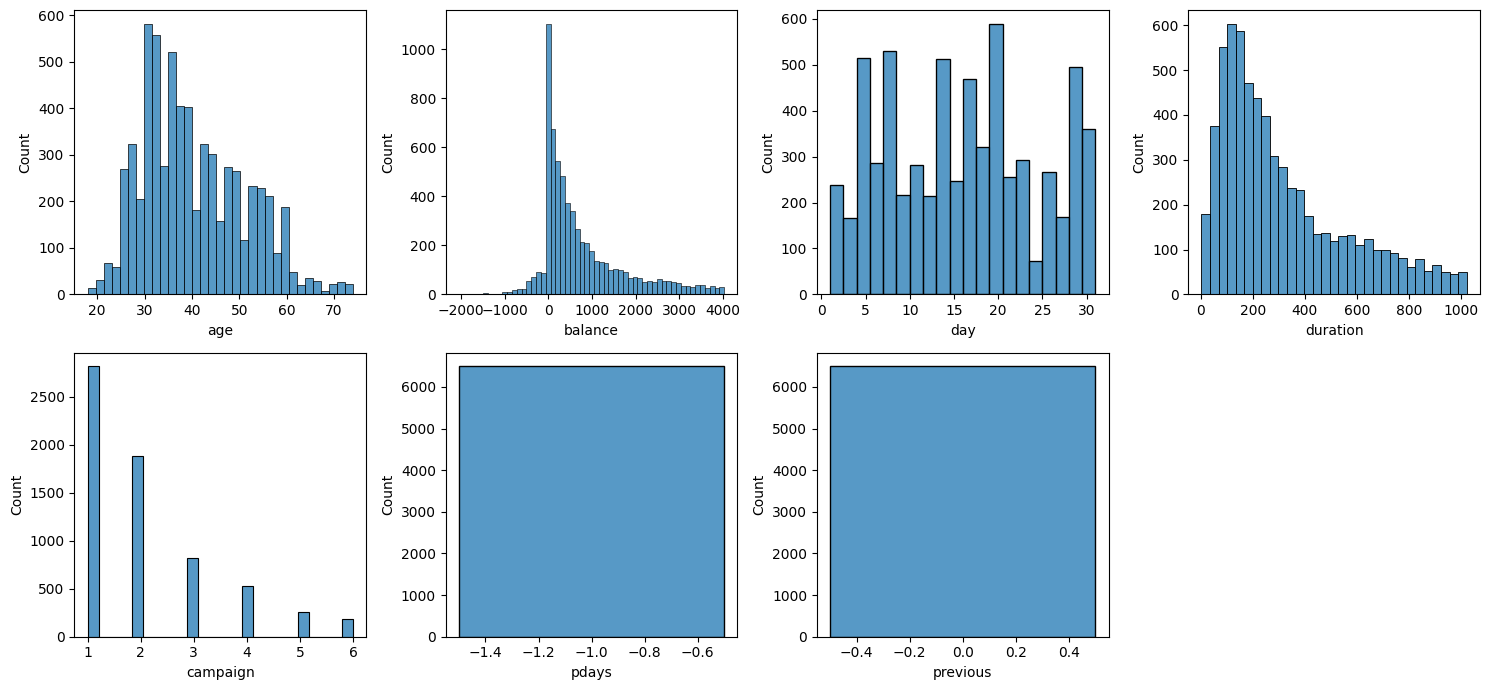

In [14]:
plt.figure(figsize=(15, 7))
for i in range(len(num_feature)):
  plt.subplot(2,4, i+1)
  sns.histplot(x = num_feature[i], data = df)
  plt.tight_layout()

#Multivariate Analysis
teknik analisis data yang melibatkan dua atau lebih variabel sekaligus. Tujuannya adalah untuk melihat bagaimana variabel-variabel tersebut berinteraksi satu sama lain, apakah ada korelasi, pola, atau pengaruh antar fitur.

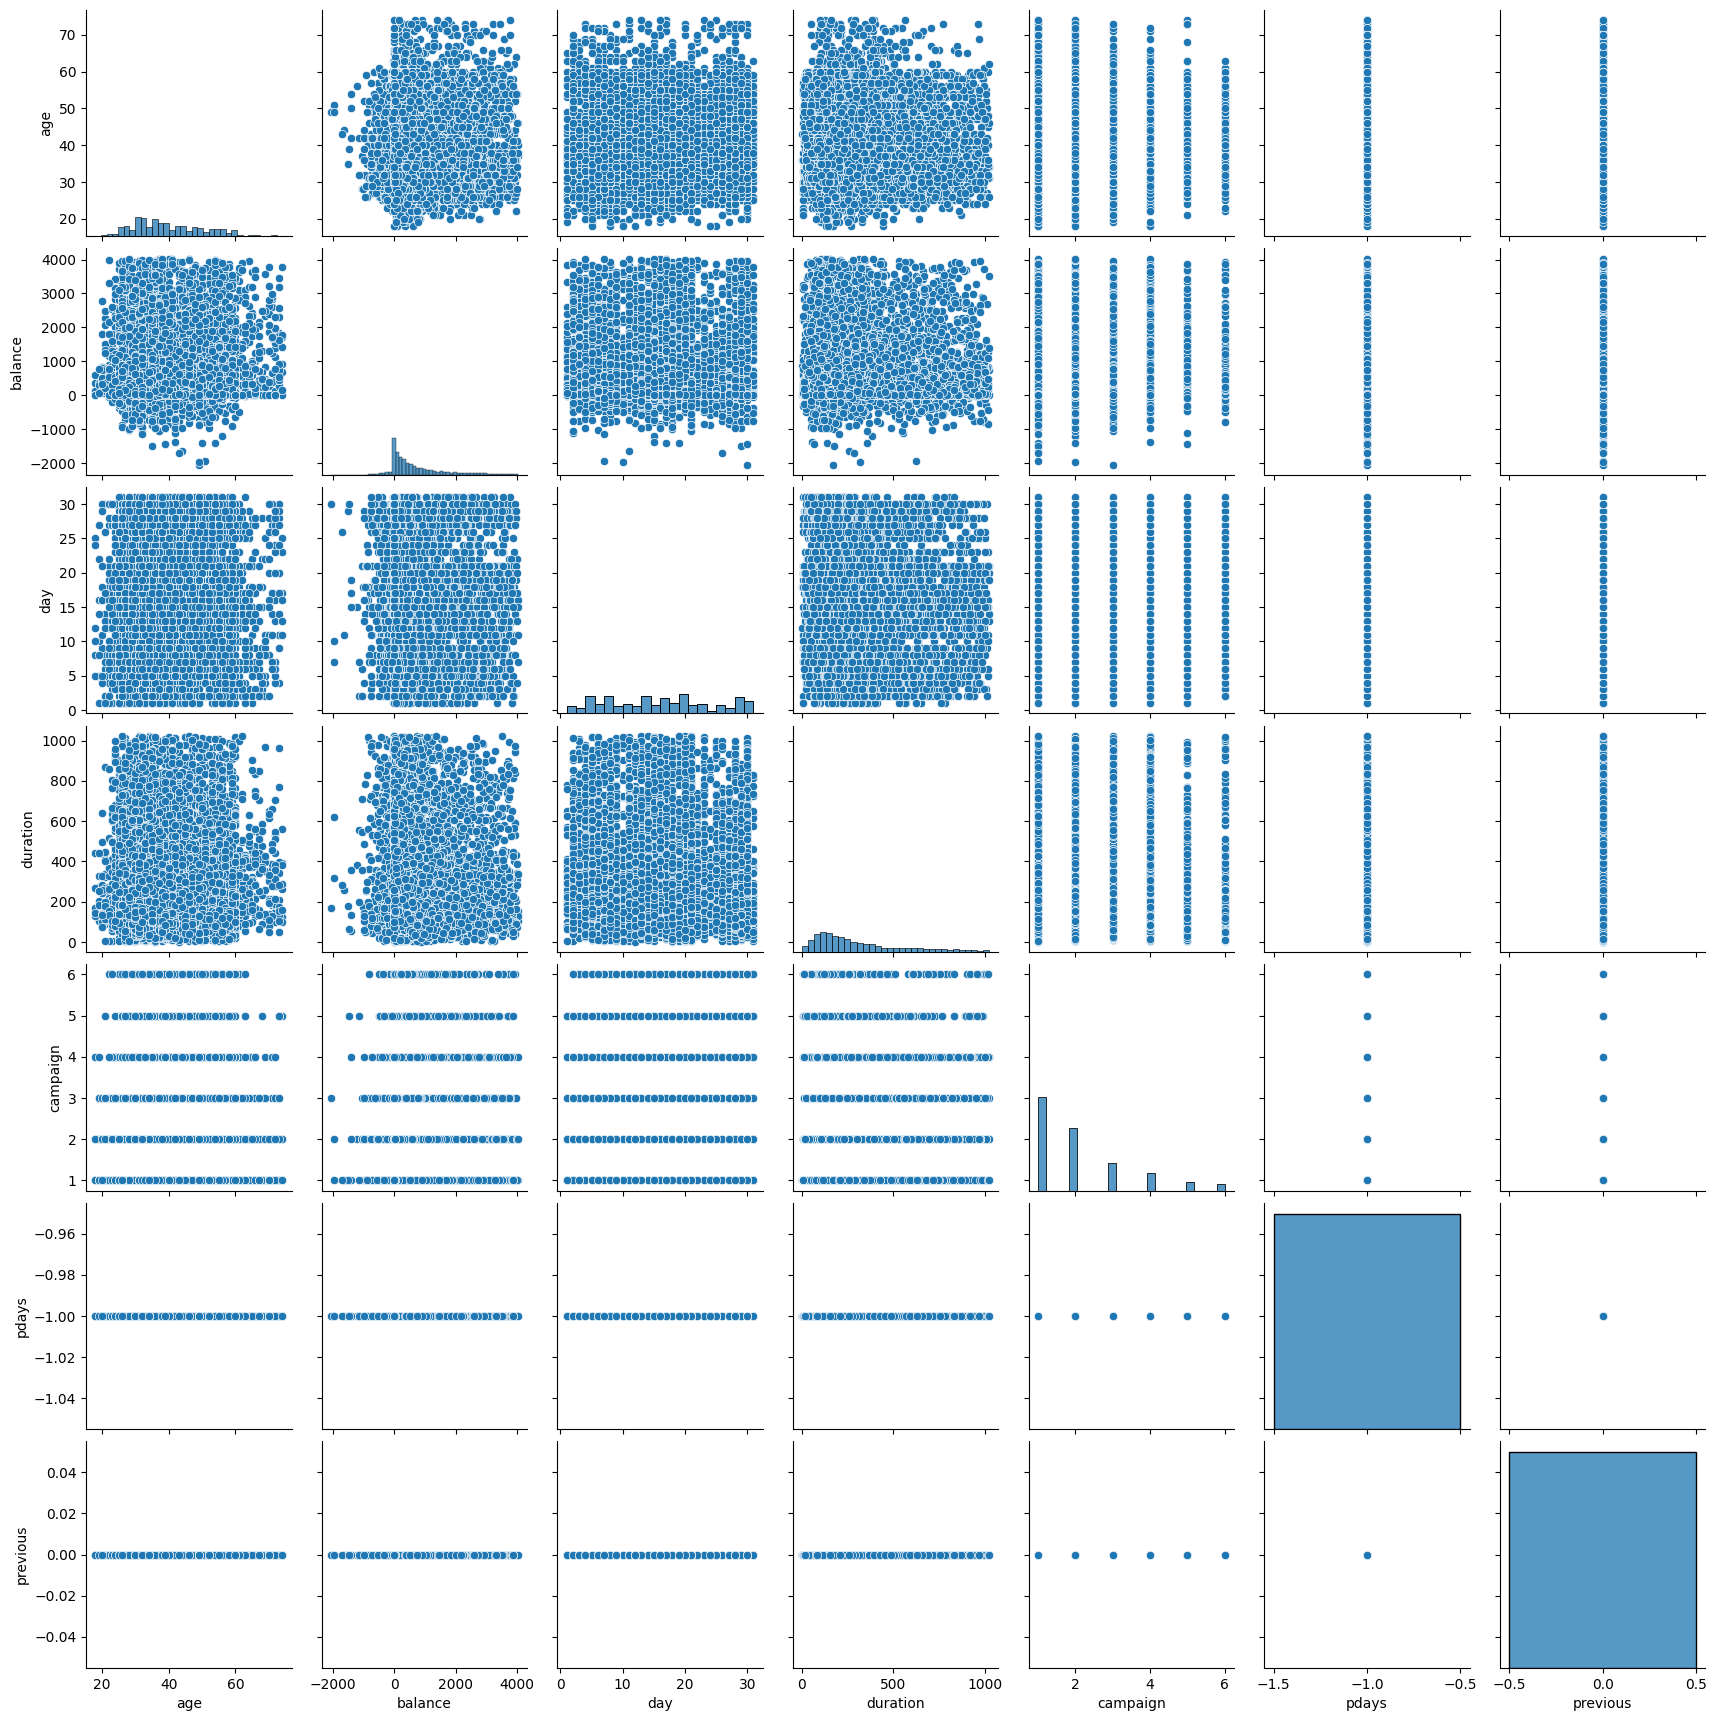

In [15]:
sns.pairplot(df[num_feature])

<Axes: >

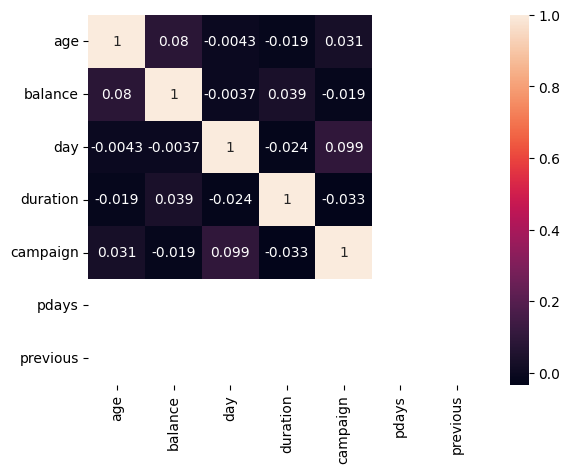

In [16]:
sns.heatmap(df[num_feature].corr(), annot = True)

#Additional Data Preparation before Modeling

##Feature Engineering
Dikarenakan kurangnya korelasi antar variabel, maka dilakukan beberapa teknik Feature Engineering pada deposit, dan memberikan feature baru bernama deposit_group untuk mengubah dan menyempurnakan fitur agar dapat meningkatkan performa model machine learning.

In [17]:
df["balance_group"] = "positive"

In [20]:
df.loc[df["balance"] < 0 , "balance_group"] = "negative"

In [21]:
df.loc[df["balance"] == 0 , "balance_group"] = "empty"

##One-Hot Encoding
memungkinkan model untuk memproses informasi kategorikal tanpa memberikan urutan atau bobot yang salah pada kategori tersebut.

In [23]:
obj_feature = df.select_dtypes(["object"]).columns.tolist()

In [25]:
obj_feature.remove("deposit")

In [27]:
df = pd.get_dummies(df, columns = obj_feature)

##Train test split

In [29]:
X = df.drop(columns = ["deposit"])
y = df["deposit"].map({"yes": 1, "no": 0})

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [35]:
print("Total data: ", X_train.shape)
print("Total data: ", X_test.shape)
print("Total data: ", y_train.shape)
print("Total data: ", y_test.shape)

Total data:  (4548, 51)
Total data:  (1950, 51)
Total data:  (4548,)
Total data:  (1950,)


#Modeling
Berdasarkan EDA, data memiliki distribusi yang tidak normal, sehingga digunakan algoritma yang tidak mengasumsikan distribusi normal, seperti Decision Tree dan Random Forest.

##Decission Tree

In [38]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

##Random Forest

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

##Random Forest Hyperparameter Tuning

In [44]:
params = {
    'max_depth': [2,3,5,10,15],
    'min_samples_leaf': [10,20,25,35,50]
}

In [45]:
grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = params,
                           cv = 5,
                           scoring = 'roc_auc'
                           )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10, 15],
                         'min_samples_leaf': [10, 20, 25, 35, 50]},
             scoring='roc_auc')

In [47]:
rf_best = grid_search.best_estimator_
rf_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10)

#Evaluasi

##Recall

In [50]:
y_dtree = dtree.predict(X_test)
y_rf = rf.predict(X_test)
y_rf_best = rf_best.predict(X_test)

In [55]:
print('DT: ',recall_score(y_test, y_dtree, pos_label = 1, average = 'binary'))
print('RF: ',recall_score(y_test, y_rf, pos_label = 1, average = 'binary'))
print('RF-Hyp: ',recall_score(y_test, y_rf_best, pos_label = 1, average = 'binary'))

DT:  0.712707182320442
RF:  0.8149171270718232
RF-Hyp:  0.7707182320441989


##Precission Score

In [57]:
print('DT: ',precision_score(y_test, y_dtree, pos_label = 1, average = 'binary'))
print('RF: ',precision_score(y_test, y_rf, pos_label = 1, average = 'binary'))
print('RF-Hyp: ',precision_score(y_test, y_rf_best, pos_label = 1, average = 'binary'))

DT:  0.7288135593220338
RF:  0.8038147138964578
RF-Hyp:  0.7914893617021277
